# MT1D layered earth: Sharp and Smooth features with PGI


## A notebook reproducing the 1D MT PGI notebook 1_MT_PGI_Sharp_Smooth

### Synopsis
Magnetotelluric data are acquired over a layered-earth that has sharp and smooth features. The earth model consists of a background unit of $0.01~\text{S/m}$, a $900~\text{m}$ thick resistive unit with sharp contrast starting at a depth of $100~\text{m}$ with a conductivity of $5\cdot10^{-3}~\text{S/m}$ (or $200~\Omega \text{m}$), and a deeper smooth conductor with a minimum resistivity of $10~\Omega \text{m}$, starting at a depth of $2,300~\text{m}$ and finishing at a depth of $7,560~\text{m}$. We discretize this model on a $89$ cells.

This notebook is to reproduce the previous PGI work to ensure the mechanics in SimPEG are producing similar results as before.


In [1]:
# Initial import
from scipy.constants import mu_0
import scipy.sparse as sp
import discretize
from SimPEG.electromagnetics import natural_source as nsem
from SimPEG import (
    maps, utils, optimization, inversion, inverse_problem, directives,
    data_misfit, regularization, data
)
from discretize import TensorMesh
from pymatsolver import Pardiso
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.ticker import StrMethodFormatter,FormatStrFormatter
from sklearn.mixture import GaussianMixture
import sys
import copy


### Mesh setup

In [2]:
# Note - taken from utilities of previous notebook
def setMesh(frequency: np.array,
            sigma: float=0.1, 
            max_depth_core: float=3000.,
            ncell_per_skind: int=10,
            n_skind: int=2,
            core_meshType: str="linear",
            max_hz_core: float=None):

    """
    Set 1D Mesh based using skin depths
    """
    rho = 1./sigma
    fmin, fmax = frequency.min(), frequency.max()
    print (
        (">> Smallest cell size = %d m") % (500*np.sqrt(rho/fmax) / ncell_per_skind)
        )
    print (
        (">> Padding distance = %d m") % (500*np.sqrt(rho/fmin) * n_skind)
        )
    cs = 500*np.sqrt(rho/fmax) / ncell_per_skind
    length_bc = 500*np.sqrt(100/fmin) * n_skind

    if core_meshType == "linear":

        max_hz_core = cs

    elif core_meshType == "log":

        if max_hz_core is None:
            max_hz_core  = cs * 10

        ncz = 2
        hz_core = np.logspace(np.log10(cs), np.log10(max_hz_core), ncz)

        while hz_core.sum() < max_depth_core:
            ncz += 1
            hz_core = np.logspace(np.log10(cs), np.log10(max_hz_core), ncz)

    npad = 1
    blength = max_hz_core*1.3**(np.arange(npad)+1)

    while blength < length_bc:
        npad += 1
        blength = (max_hz_core*1.3**(np.arange(npad)+1)).sum()
    print (
        (">> # of padding cells %d") % (npad)
    )

    if core_meshType == "linear":
        ncz = int(max_depth_core / cs)
        hz = [(cs, npad, -1.3), (cs, ncz)]
    elif core_meshType == "log":
        hz_pad = max_hz_core * 1.3**(np.arange(npad)+1)
        hz = np.r_[hz_pad[::-1], hz_core[::-1]]

    print (
        (">> # of core cells cells %d") % (ncz)
        )
    mesh = TensorMesh([hz], x0='N')

    return mesh


### Model and Simulation Setup

>> Smallest cell size = 7 m
>> Padding distance = 316227 m
>> # of padding cells 17
>> # of core cells cells 72


/home/juan/anaconda3/envs/inversion/lib/python3.9/site-packages/discretize/utils/code_utils.py:217: FutureWarning: TensorMesh.plotGrid has been deprecated, please use TensorMesh.plot_grid. It will be removed in version 1.0.0 of discretize.
  warnings.warn(
/home/juan/anaconda3/envs/inversion/lib/python3.9/site-packages/discretize/utils/code_utils.py:182: FutureWarning: TensorMesh.vectorCCx has been deprecated, please use TensorMesh.cell_centers_x. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/juan/anaconda3/envs/inversion/lib/python3.9/site-packages/discretize/utils/code_utils.py:217: FutureWarning: TensorMesh.getInterpolationMat has been deprecated, please use TensorMesh.get_interpolation_matrix. It will be removed in version 1.0.0 of discretize.
  warnings.warn(


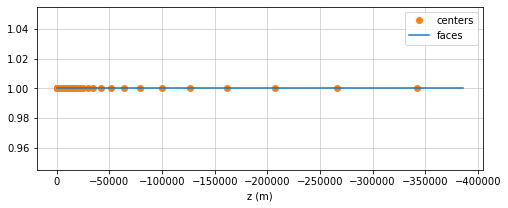

In [3]:
# Initialize the Earth-model
layer_tops = np.r_[0., -100., -1000.]  # in m
rho_layers = np.r_[100., 200., 100.]

# Initialize the survey
rx_loc = np.r_[0.]
frequencies = np.logspace(-3, 3, 25)

# Create a receiver object list
rx_list = [

    nsem.receivers.PointNaturalSource(
        rx_loc, orientation="yx", component="real"
    ),
    nsem.receivers.PointNaturalSource(
        rx_loc, orientation="yx", component="imaginary"
    ),

]

# create the source list
src_list = [nsem.sources.Planewave(rx_list, frequency=f) for f in frequencies]

# Define the mesh
max_depth_core = 15000.
mesh = setMesh(
    
    frequencies,
    sigma=0.01,  # approximate conductivity of the background
    max_depth_core=max_depth_core,  # extent of the core region of the mesh
    ncell_per_skind=20,  # number of cells per the smallest skin depth
    n_skind=2,  # number of skin depths that the mesh should extend to ensure the lowest-frequency fields have decayed
    core_meshType="log",   # cell spacings in the core region of the mesh ("linear" or "log")
    max_hz_core=1000.  # If using a logarithmic core mesh, what is the maximum cell size?
 
)

# plot the mesh
fig, ax = plt.subplots(1,1, figsize=(8, 3))
mesh.plotGrid(centers=True, faces=True, ax=ax)
ax.legend(["centers", "faces"])
ax.invert_xaxis()  # so that the surface is on our left hand side
ax.set_xlabel('z (m)')
ax.grid(which="both", linewidth=0.5)

# define a survey
survey = nsem.Survey(src_list)

# Create the simulation
sim = nsem.simulation.Simulation1DMagneticField(
    mesh,
    survey=survey,
    sigmaMap=maps.ExpMap(mesh),
    solver=Pardiso,
)

# start with nans so we can do a check to make sure all
# layer conductivities have been properly assigned
rho = np.ones(mesh.nC) * np.nan

# loop over each layer in the model and assign to mesh
for layer_top, rho_layer in zip(layer_tops, rho_layers):
    inds = mesh.vectorCCx < layer_top
    rho[inds] = rho_layer

# Add a smooth unit
sigma = 1./rho
mtrue = np.log(sigma)
t = (mesh.vectorCCx+5000.)/5e3
indx = np.abs(t) < 1
maux = copy.deepcopy(mtrue)
maux[indx] = (np.log(1./100.)*(1-(((1-t**2.)**2.)))-np.log(10))[indx]
indx = np.logical_and(indx, maux > np.log(1./rho_layers[2]))
mtrue[indx] = maux[indx]
dtrue = sim.dpred(mtrue)  # these are clean data (no noise yet.)

std = 0.05  # standard deviation of the noise (10%)

# add noise
uncertTrue = std * np.abs(dtrue)
noise = uncertTrue * np.random.randn(frequencies.shape[0] * 2)
survey.dobs = dtrue + noise
survey.std = uncertTrue # changed this from original notebook
survey.eps = 0.
uncert = std * np.abs(survey.dobs)


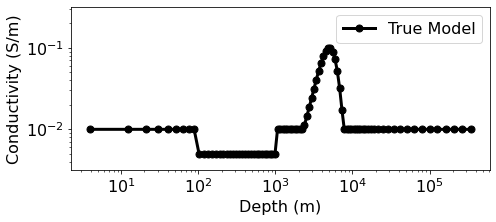

In [4]:
# Plot the true model
fig0 = plt.figure(figsize=(7.5,3))
ax1 = fig0.add_subplot(111)

fontsize=16
M = sim.mesh

plt.loglog(-M.vectorCCx, np.exp(mtrue), 'ko-',linewidth=3,label='True Model',ms=7)
plt.legend(fontsize=fontsize,loc=0)
plt.gca().set_ylim([10**(-2.5),10**(-0.5)])
plt.gca().set_xlabel('Depth (m)',fontsize=fontsize)
plt.gca().tick_params(labelsize=fontsize)
plt.gca().set_ylabel('Conductivity (S/m)',fontsize=fontsize)
plt.show()


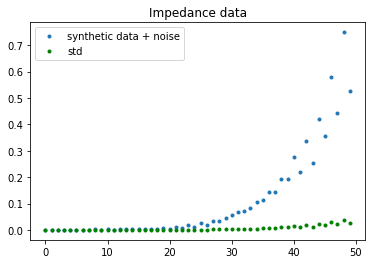

In [5]:
survey.std = uncert
plt.plot(survey.dobs, '.')
plt.plot(survey.std, '.g')
plt.legend(['synthetic data + noise', 'std'])
plt.title('Impedance data')
plt.show()
data_t = data.Data(survey, dobs=survey.dobs, standard_deviation=survey.std)

## Tikhonov Inversion

In [20]:
# Simple Inversion
##################

# Set the initial and reference models
sigma_ref = 1./rho_layers[0]  # reference conductivity
sigma_0 = 1./rho_layers[0]  # starting conductivity

# translate the starting and reference model to log-conductivity
mref = np.log(sigma_ref)*np.ones(mesh.nC)
m0 = np.log(sigma_0)*np.ones(mesh.nC)

# Set weighting parameters
alpha_s = 1e-2  # smallness contribution
alpha_z = 20000.  # smoothness contribution to the regularization
beta = 4e-1  # Initial beta
beta0_ratio = 100.   # starting contribution of regularization 100x larger than the data misfit
coolingFactor = 1.5
coolingRate = 1

# Data misfit
dmisfit = data_misfit.L2DataMisfit(data=data_t, simulation=sim)
dmisfit.W = 1./uncert

# Regularization
reg = regularization.Tikhonov(
        sim.mesh, alpha_s=alpha_s, alpha_x=alpha_z, mref=mref
    )  # since we are in 1D, we work with the first dimension

# Optimization
opt = optimization.ProjectedGNCG(
    maxIter=35, tolX=1e-6, maxIterCG=100, tolCG=1e-3)
opt.remember('xc')

# Statement of the inverse problem
invProb = inverse_problem.BaseInvProblem(dmisfit, reg, opt)
invProb.beta = beta

# Inversion Directives
beta = directives.BetaSchedule(
        coolingFactor=coolingFactor, coolingRate=coolingRate
    )
target = directives.TargetMisfit()
directives_list = [beta, target]

# assemble in an inversion
inv = inversion.BaseInversion(invProb, directiveList=directives_list)
# prob.counter = opt.counter = Utils.Counter()
opt.remember('xc')

# run the inversion
l2model = inv.run(m0)


        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0


/home/juan/anaconda3/envs/inversion/lib/python3.9/site-packages/pymatsolver/direct.py:23: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format, will slow down.
  self.solver = MKLPardisoSolver(


   0  4.00e-01  2.76e+03  0.00e+00  2.76e+03    8.43e+02      0              


/home/juan/anaconda3/envs/inversion/lib/python3.9/site-packages/pymatsolver/direct.py:73: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format, will slow down.
  self.solver.refactor(self.A)


   1  2.67e-01  9.38e+01  1.38e+02  1.31e+02    6.07e+01      0              
   2  1.78e-01  3.44e+01  1.35e+02  5.84e+01    3.56e+01      0              
   3  1.19e-01  2.75e+01  1.33e+02  4.33e+01    3.05e+00      0              
   4  7.90e-02  2.65e+01  1.39e+02  3.75e+01    2.50e+00      0   Skip BFGS  
   5  5.27e-02  2.59e+01  1.46e+02  3.36e+01    2.00e+00      0   Skip BFGS  
   6  3.51e-02  2.53e+01  1.55e+02  3.07e+01    1.58e+00      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 2.7636e+02
0 : |xc-x_last| = 2.0602e-01 <= tolX*(1+|x0|) = 4.4445e-05
0 : |proj(x-g)-x|    = 1.5799e+00 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 1.5799e+00 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =      35    <= iter          =      7
------------------------- DONE! -------------------------


/home/juan/anaconda3/envs/inversion/lib/python3.9/site-packages/discretize/utils/code_utils.py:182: FutureWarning: TensorMesh.vectorCCx has been deprecated, please use TensorMesh.cell_centers_x. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/juan/anaconda3/envs/inversion/lib/python3.9/site-packages/discretize/utils/code_utils.py:182: FutureWarning: TensorMesh.vectorCCx has been deprecated, please use TensorMesh.cell_centers_x. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/juan/anaconda3/envs/inversion/lib/python3.9/site-packages/discretize/utils/code_utils.py:182: FutureWarning: TensorMesh.vectorCCx has been deprecated, please use TensorMesh.cell_centers_x. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)


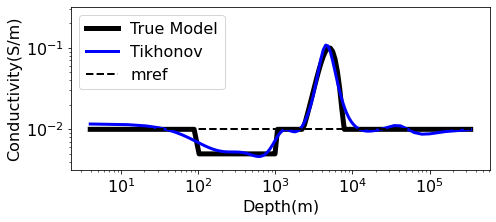

In [21]:
M = mesh
fontsize=16
fig,ax0 = plt.subplots(1,1,figsize=(7.5,3))
ax0.loglog(-M.vectorCCx, np.exp(mtrue),color='black', linewidth=5.)
ax0.loglog(-M.vectorCCx, np.exp(l2model),color='b', linewidth=3.)
ax0.loglog(-M.vectorCCx, np.exp(m0),
             color='black',
             linestyle='dashed',
          linewidth=2)

plt.legend(['True Model',
            'mref',
            'Petro',
            'L2 model'],fontsize=fontsize,loc=0)
plt.gca().set_ylim([10**(-2.5),10**(-0.5)])


plt.gca().set_xlabel('Depth (m)',fontsize=fontsize)
plt.gca().tick_params(labelsize=fontsize)
plt.gca().set_ylabel('Conductivity (S/m)',fontsize=fontsize)
ax0.legend(('True Model', 'Tikhonov', 'mref'),loc=0,fontsize=fontsize)
ax0.set_xlabel("Depth(m)",fontsize=fontsize)
fig.canvas.draw()
ax0.set_ylabel("Conductivity(S/m)",fontsize=fontsize)
ax0.tick_params(labelsize=fontsize)

## PGI

In [22]:
# Compute the GMM parameters for each units
bckgdmean = -np.log(100)
bckgrdvar = 0.01
bckgrdprop = np.sum(mesh.vol[np.isclose(bckgdmean,mtrue)])/np.sum(mesh.vol)

resmean = -np.log(200)
resvar = 0.01
resprop = np.sum(mesh.vol[np.isclose(resmean,mtrue)])/np.sum(mesh.vol)

values = maux[indx]
weights = mesh.vol[indx]

# determine the mean and variance
cond_mean = np.average(values, weights=weights)

# Fast and numerically precise:
cond_variance = np.average((values - cond_mean)**2., weights=weights)

cond_prop = 1. -(bckgrdprop + resprop)

/home/juan/anaconda3/envs/inversion/lib/python3.9/site-packages/discretize/utils/code_utils.py:182: FutureWarning: TensorMesh.vol has been deprecated, please use TensorMesh.cell_volumes. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)


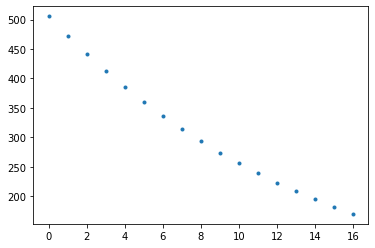

0.44627184339637394


In [23]:
plt.plot(weights, '.')
plt.show()
print(cond_variance)

## Create the Prior GMM

In [30]:
# ==================================================================

# Create the Prior GMM

#

gmmref = utils.WeightedGaussianMixture(
    
    n_components=3,
    mesh=mesh,
    covariance_type='full',
    max_iter=1000,
    n_init=1,
    reg_covar=4e-3,

)

gmmref.fit(mtrue.reshape(-1, 1))

gmmref.means = np.c_[[-np.log(100)], [cond_mean], [-np.log(200)]]

gmmref.covariances_ = np.array([[[0.01]],
                             [[cond_variance]],
                             [[0.01]],
                             ])

gmmref.compute_clusters_precisions()
                     
gmmref.weights_ = np.r_[bckgrdprop, cond_prop, resprop]


/home/juan/anaconda3/envs/inversion/lib/python3.9/site-packages/discretize/utils/code_utils.py:182: FutureWarning: TensorMesh.vol has been deprecated, please use TensorMesh.cell_volumes. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)


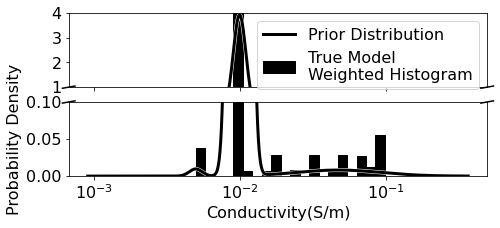

In [31]:
# Plot the Prior GMM distribution
fig0, (ax, ax3) = plt.subplots(2, 1, sharex=True,figsize=(7.5,3))
fontsize=16
M = sim.mesh
testXplot = np.linspace(-7.,-1.,1000)[:,np.newaxis];
clfinv = gmmref
log_dens0 = gmmref.score_samples(testXplot);
log_dens = clfinv.score_samples(testXplot);
ax3.plot(np.log10(np.exp(testXplot)), np.exp(log_dens0),linewidth =3.,color='black',
         path_effects=[pe.Stroke(linewidth=4, foreground='w'), pe.Normal()]
        )

ax3.set_xticks([-3,-2,-1])
ax3.tick_params(labelsize=fontsize)
ax3.xaxis.set_major_formatter(FormatStrFormatter('$10^{%.0f}$'))
ax3.set_xlabel('Conductivity(S/m)',fontsize=fontsize)
ax3.hist(np.log10(np.exp((mtrue))),density = True, bins = 20,color='k',ec='k', weights=mesh.vol);
ax3.set_ylim([0.,0.1])
ax3.set_ylabel("Probability Density",fontsize=fontsize)

ax.hist(np.log10(np.exp((mtrue))),density = True, bins = 20,color='k',ec='k', weights=mesh.vol/np.sum(mesh.vol));
ax.tick_params(labelsize=fontsize)
ax.plot(np.log10(np.exp(testXplot)), np.exp(log_dens0),linewidth =3.,color='black',
         path_effects=[pe.Stroke(linewidth=4, foreground='w'), pe.Normal()]
        )

ax.set_ylim([1.,4.])
ax.set_yticks([1,2,3,4])
ax.legend(['Prior Distribution','True Model\nWeighted Histogram','$m_0$ Hist'],loc=1,fontsize=fontsize)

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax3.transAxes)  # switch to the bottom axes
ax3.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax3.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

plt.show()

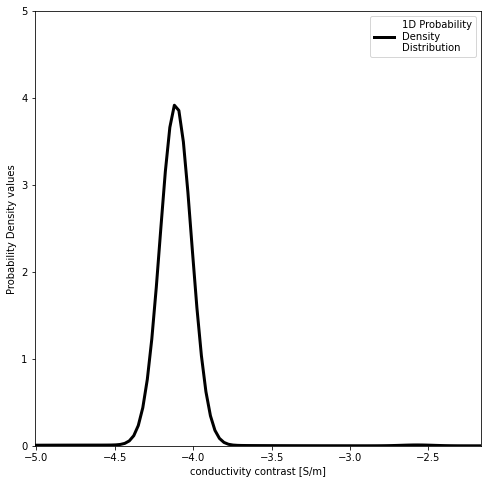

In [26]:
# Plot the 2D GMM
ax = gmmref.plot_pdf(flag2d=False)
ax[0].set_xlabel("conductivity contrast [S/m]")
ax[0].set_ylim([0, 5])
# ax[2].set_ylabel("magnetic Susceptibility [SI]")
# ax[2].set_xlim([0, 100])
plt.show()

## Create PGI regularization

In [48]:
# Petrophysics Inversion
########################

# Data misfit
dmisfit = data_misfit.L2DataMisfit(data=data_t, simulation=sim)
dmisfit.W = 1. / (uncert)

reg = regularization.PGI(
    
    gmmref=gmmref,
    mesh=sim.mesh,
    alpha_s=1,
    alpha_x=0,
    alpha_y=0,
    alpha_z=0,
    alpha_xx=0.0,
    alpha_yy=0.0,
    alpha_zz=20.0,
#     cell_weights_list = [np.ones(mesh.nC)]

)

# reg_petro.mrefInSmooth = False




In [49]:
opt = optimization.ProjectedGNCG(

    maxIter=15, tolX=1e-6, maxIterCG=100, tolCG=1e-3

)
opt.remember('xc')

# Statement of the inverse problem
invProb = inverse_problem.BaseInvProblem(dmisfit, reg, opt)
invProb.beta =4e-1

alpha0_ratio = np.r_[
    np.zeros(len(reg.objfcts)),
    1e-4 * np.ones(len(reg.objfcts)),
    100.0 * 1e-4 * np.ones(len(reg.objfcts)),
]
Alphas = directives.AlphasSmoothEstimate_ByEig(alpha0_ratio=alpha0_ratio, verbose=True)

# initialize beta and beta/alpha_s schedule
beta = directives.BetaEstimate_ByEig(beta0_ratio=1e2)

betaIt = directives.PGI_BetaAlphaSchedule(
    verbose=True,
    coolingFactor=2.0,
    tolerance=0.2,
    progress=0.2,
)

# geophy. and petro. target misfits
targets = directives.MultiTargetMisfits(
    
    verbose=True,

)

# add learned mref in smooth once stable
MrefInSmooth = directives.PGI_AddMrefInSmooth(
    wait_till_stable=True,
    verbose=True,
)
# update the parameters in smallness (L2-approx of PGI)
update_smallness = directives.PGI_UpdateParameters(
    update_gmm=True  # keep GMM model fixed
)

# scaling_init = directives.ScalingMultipleDataMisfits_ByEig(chi0_ratio=[1.0, 100.0])

# scale_schedule = directives.JointScalingSchedule(verbose=True)



directives_list = [
              
#     Alphas,
#     scaling_init,
    beta,
#     update_smallness,
    targets,
#     scale_schedule,
    betaIt,
    MrefInSmooth, 

]

# assemble in an inversion
inv = inversion.BaseInversion(invProb, directiveList=directives_list)

# run the inversion
mcluster = inv.run(m0)


SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.13e-03  2.76e+03  0.00e+00  2.76e+03    8.43e+02      0              
geophys. misfits: 529.1 (target 25.0 [False]) | smallness misfit: 1153.4 (target: 44.5 [False])
Beta cooling evaluation: progress: [529.1] ; minimum progress targets: [2210.1]
mref changed in  47  places
   1  2.13e-03  5.29e+02  2.82e+05  1.13e+03    1.51e+02      0              
geophys. misfits: 465.5 (target 25.0 [False]) | smallness misfit: 1227.9 (target: 44.5 [False])
Beta cooling evaluation: progress: [465.5] ; minimum progress targets:

/home/juan/anaconda3/envs/inversion/lib/python3.9/site-packages/discretize/utils/code_utils.py:182: FutureWarning: TensorMesh.vectorCCx has been deprecated, please use TensorMesh.cell_centers_x. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/juan/anaconda3/envs/inversion/lib/python3.9/site-packages/discretize/utils/code_utils.py:182: FutureWarning: TensorMesh.vectorCCx has been deprecated, please use TensorMesh.cell_centers_x. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/juan/anaconda3/envs/inversion/lib/python3.9/site-packages/discretize/utils/code_utils.py:182: FutureWarning: TensorMesh.vectorCCx has been deprecated, please use TensorMesh.cell_centers_x. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)


Text(0, 0.5, 'Conductivity (S/m)')

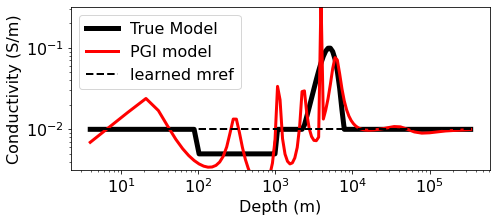

In [50]:
# PGI model
fig,ax0 = plt.subplots(1,1,figsize=(7.5,3))
fontsize=16
M = sim.mesh
plt.loglog(-M.vectorCCx, np.exp(mtrue), color='black',linewidth=5)

plt.loglog(-M.vectorCCx, np.exp(mcluster), color='r',linewidth=3)
plt.loglog(-M.vectorCCx, np.exp(reg.objfcts[0].mref),
             color='black',
             linestyle='dashed',
          linewidth=2)

plt.legend(['True Model',
            'PGI model',
            'learned mref',
],fontsize=fontsize,loc=0)
plt.gca().set_ylim([10**(-2.5),10**(-0.5)])


plt.gca().set_xlabel('Depth (m)',fontsize=fontsize)
plt.gca().tick_params(labelsize=fontsize)
plt.gca().set_ylabel('Conductivity (S/m)',fontsize=fontsize)

In [ ]:
survey.nD